# ML Preprocessing Pipeline 

This notebook implements the complete preprocessing and feature engineering recommendations.

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer, FunctionTransformer, KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor

from sentence_transformers import SentenceTransformer

from sklearn import set_config
set_config(transform_output="pandas") 

warnings.filterwarnings('ignore', category=UserWarning)
pd.options.display.max_columns = 100

## 1. Data Loading 

In [2]:
load_dotenv("config/.env")
DATA_CLEANED = os.getenv("URL_CLEANED_DATA")

print(f"Loading cleaned data from: {DATA_CLEANED}")
df = pl.read_parquet(DATA_CLEANED)

df_sample = df.sample(n=1000, seed=42)
print(f"Full dataset shape: {df.shape}")
print(f"Sample dataset shape: {df_sample.shape}")

df_sample_pd = df_sample.to_pandas()
print(f"\nSchema: {df_sample.schema}")

Loading cleaned data from: https://huggingface.co/datasets/wojciechjurewicz/imdb/resolve/main/imdb_us_movies_cleaned.parquet
Full dataset shape: (390855, 11)
Sample dataset shape: (1000, 11)

Schema: Schema([('num__isAdult', Float64), ('num__startYear', Float64), ('num__runtimeMinutes', Float64), ('num__averageRating', Float64), ('num__numVotes', Float64), ('cat__title', String), ('cat__types', String), ('cat__genres', String), ('remainder__cast', List(Struct({'category': String, 'job': String, 'characters': String, 'primaryName': String, 'primaryProfession': String, 'birthYear': Int64, 'deathYear': Int64}))), ('remainder__directors', List(Struct({'primaryName': String, 'birthYear': Int64, 'deathYear': Int64}))), ('remainder__writers', List(Struct({'primaryName': String, 'birthYear': Int64, 'deathYear': Int64})))])


## 2. Foundational Cleansing 

First, we must convert our placeholders (e.g., -1, "missing") back to standard nulls (`np.nan`). This is critical for creating accurate "missingness indicators" and correcting data types.

###  Custom Transformer: PlaceholderToNull

In [3]:
class PlaceholderToNullTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.numeric_cols:
            X_copy[col] = X_copy[col].replace(-1.0, np.nan)
        for col in self.categorical_cols:
            X_copy[col] = X_copy[col].replace("missing", np.nan)
        return X_copy

print("Custom 'PlaceholderToNullTransformer' created.")

Custom 'PlaceholderToNullTransformer' created.


### Custom Transformer: TypeCorrector

In [4]:
class TypeCorrector(BaseEstimator, TransformerMixin):
    def __init__(self, int_cols, float_cols, obj_cols):
        self.int_cols = int_cols
        self.float_cols = float_cols
        self.obj_cols = obj_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.int_cols:
            X_copy[col] = X_copy[col].astype(pd.Int64Dtype())
        for col in self.float_cols:
            X_copy[col] = X_copy[col].astype(float)
        for col in self.obj_cols:
            X_copy[col] = X_copy[col].astype(str).replace('<NA>', np.nan) # Ensure object
        return X_copy

print("Custom 'TypeCorrector' created.")

Custom 'TypeCorrector' created.


### Foundational Pipeline (Test)

In [5]:
numeric_cols = [c for c in df_sample_pd.columns if c.startswith('num__')]
categorical_cols = [c for c in df_sample_pd.columns if c.startswith('cat__')]

int_cols = ['num__isAdult', 'num__startYear', 'num__numVotes']
float_cols = ['num__averageRating', 'num__runtimeMinutes']
obj_cols = categorical_cols

foundational_pipeline = Pipeline(steps=[
    ('placeholders_to_null', PlaceholderToNullTransformer(numeric_cols, categorical_cols)),
    ('type_corrector', TypeCorrector(int_cols, float_cols, obj_cols))
])

df_clean = foundational_pipeline.fit_transform(df_sample_pd)

print("--- Schema Before ---")
df_sample_pd.info()
print("\n--- Schema After ---")
df_clean.info()

--- Schema Before ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num__isAdult          1000 non-null   float64
 1   num__startYear        1000 non-null   float64
 2   num__runtimeMinutes   1000 non-null   float64
 3   num__averageRating    1000 non-null   float64
 4   num__numVotes         1000 non-null   float64
 5   cat__title            1000 non-null   object 
 6   cat__types            1000 non-null   object 
 7   cat__genres           1000 non-null   object 
 8   remainder__cast       1000 non-null   object 
 9   remainder__directors  1000 non-null   object 
 10  remainder__writers    1000 non-null   object 
dtypes: float64(5), object(6)
memory usage: 86.1+ KB

--- Schema After ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                N

### Interpretation

Success. The `num__` columns are now `Int64` (nullable integers) or `float64`, and we have `NaN` values instead of placeholders. We are now ready for proper feature engineering.

## Parse `principals` Column (The #1 Fix)

We cannot filter by 'actor,' 'director,' or 'writer' if all crew names are smashed into one text column. 
The parse_crew_and_cast function is a structural preprocessing step designed to flatten complex, nested data structures using Polars. It transforms the raw List(Struct) columns from the Parquet file into clean, usable columns for the machine learning pipeline.

In [ ]:
def parse_crew_and_cast(df: pl.DataFrame) -> pl.DataFrame:
    """Parses structured crew columns into flat, usable columns."""
    director_expr = pl.col("remainder__directors").list.first().struct.field("primaryName").alias("director_name")
    
    actor_names_expr = (
        pl.col("remainder__cast")
        .list.eval(pl.element().struct.field("primaryName"))
        .alias("actor_names_list")
    )

    writer_names_expr = (
        pl.col("remainder__writers")
        .list.eval(pl.element().struct.field("primaryName"))
        .alias("writer_names_list")
    )
    
    return df.select(pl.all(), director_expr, actor_names_expr, writer_names_expr)


df_parsed_pl = parse_crew_and_cast(df_sample)
df_sample_pd = df_parsed_pl.to_pandas()

numeric_cols = [c for c in df_sample_pd.columns if c.startswith('num__')]
categorical_cols = [c for c in df_sample_pd.columns if c.startswith('cat__')]

int_cols = ['num__isAdult', 'num__startYear', 'num__numVotes']
float_cols = ['num__averageRating', 'num__runtimeMinutes']
obj_cols = categorical_cols

foundational_pipeline = Pipeline(steps=[
    ('placeholders_to_null', PlaceholderToNullTransformer(numeric_cols, categorical_cols)),
    ('type_corrector', TypeCorrector(int_cols, float_cols, obj_cols))
])

df_clean = foundational_pipeline.fit_transform(df_sample_pd)

print(f"df_clean shape: {df_clean.shape}")
print("Columns in df_clean:", df_clean.columns.tolist())

df_clean shape: (1000, 14)
Columns in df_clean: ['num__isAdult', 'num__startYear', 'num__runtimeMinutes', 'num__averageRating', 'num__numVotes', 'cat__title', 'cat__types', 'cat__genres', 'remainder__cast', 'remainder__directors', 'remainder__writers', 'director_name', 'actor_names_list', 'writer_names_list']


## 3. Feature Engineering Pipeline

### Custom Transformer: Search Corpus Generator

In [7]:
class SearchCorpusGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def _flatten_list(self, list_of_names):
        # Handles both list of names and single string/nan gracefully
        if isinstance(list_of_names, list):
            return " ".join(list_of_names).replace("nan", "").strip()
        elif isinstance(list_of_names, str):
            return list_of_names
        return ""

    def transform(self, X):
        X_copy = X.copy()
        
        # Prepare text components
        X_copy['director_text'] = X_copy['director_name'].fillna('')
        X_copy['actors_text'] = X_copy['actor_names_list'].apply(self._flatten_list)
        X_copy['writers_text'] = X_copy['writer_names_list'].apply(self._flatten_list)
        X_copy['genres_text'] = X_copy['cat__genres'].fillna('').str.replace(',', ' ')
        
        # Create the unified searchable text column
        X_copy['searchable_text'] = (
            X_copy['cat__title'].fillna('') + ' ' +
            X_copy['genres_text'] + ' ' +
            X_copy['director_text'] + ' ' +
            X_copy['actors_text'] + ' ' +
            X_copy['writers_text']
        )
        
        # Return the search corpus AND the structured columns for filtering
        return X_copy[['searchable_text', 'director_name', 'actor_names_list', 'writer_names_list']]

print("Custom 'SearchCorpusGenerator' created.")

Custom 'SearchCorpusGenerator' created.


### Custom Transformer: Numerical Ranking Features

In [8]:
class NumericalRankingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, log_cols, clip_cols, clip_quantile=0.99):
        self.log_cols = log_cols
        self.clip_cols = clip_cols
        self.clip_quantile = clip_quantile
        self.clip_values_ = {}
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        for col in self.clip_cols:
            self.clip_values_[col] = X[col].quantile(self.clip_quantile)
        
        X_transformed_for_fit = self.transform(X, fit_scaler=False)
        self.scaler.fit(X_transformed_for_fit)
        return self

    def transform(self, X, fit_scaler=True):
        X_copy = X.copy()
        indicator_cols = []
        
        for col in X_copy.columns:
            if X_copy[col].isnull().any():
                indicator_col_name = f'is_missing_{col}'
                X_copy[indicator_col_name] = X_copy[col].isnull().astype(int)
                indicator_cols.append(indicator_col_name)
                X_copy[col] = X_copy[col].fillna(0) 

        for col in self.log_cols:
            X_copy[f'{col}_log'] = np.log1p(X_copy[col])
            X_copy = X_copy.drop(columns=[col]) 
            
        for col in self.clip_cols:
            if col in self.clip_values_: 
                clip_val = self.clip_values_[col]
                X_copy[col] = X_copy[col].clip(upper=clip_val)

        if fit_scaler:
            X_scaled = self.scaler.transform(X_copy)
            X_copy = pd.DataFrame(X_scaled, columns=X_copy.columns, index=X_copy.index)
        
        return X_copy

print("Custom 'NumericalRankingTransformer' created.")

Custom 'NumericalRankingTransformer' created.


### Custom Transformer: UI Binning Features

In [9]:
class FeatureBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        year_bins = [1870, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, np.inf]
        year_labels = ['<1950', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
        X_copy['year_bin'] = pd.cut(X_copy['num__startYear'], bins=year_bins, labels=year_labels, right=False)
        
        runtime_bins = [-np.inf, 60, 90, 120, np.inf]
        runtime_labels = ['< 60 min', '60-90 min', '90-120 min', '120+ min']
        X_copy['runtime_bin'] = pd.cut(X_copy['num__runtimeMinutes'], bins=runtime_bins, labels=runtime_labels, right=False)
        
        rating_bins = [-np.inf, 4, 6, 8, np.inf]
        rating_labels = ['Low (0-4)', 'Medium (4-6)', 'High (6-8)', 'Excellent (8+)']
        X_copy['rating_bin'] = pd.cut(X_copy['num__averageRating'], bins=rating_bins, labels=rating_labels, right=False)

        bin_cols = ['year_bin', 'runtime_bin', 'rating_bin']
        return X_copy[bin_cols].astype(str)

print("Custom 'FeatureBinner' created.")

Custom 'FeatureBinner' created.


### Custom Transformer: Genre Binarizer

In [10]:
class GenresBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        data_split = X.fillna('').str.split(',')
        self.mlb.fit(data_split)
        return self

    def transform(self, X):
        data_split = X.fillna('').str.split(',')
        return self.mlb.transform(data_split)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

print("Custom 'GenresBinarizer' created.")

Custom 'GenresBinarizer' created.


## 4. Pipeline Integration

In [16]:
numeric_cols = ['num__isAdult', 'num__startYear', 'num__runtimeMinutes', 'num__averageRating', 'num__numVotes']
corpus_cols = ['cat__title', 'cat__genres', 'director_name', 'actor_names_list', 'writer_names_list']
binner_cols = ['num__startYear', 'num__runtimeMinutes', 'num__averageRating']
onehot_cols = ['cat__types']
multilabel_cols = 'cat__genres'


full_preprocessor = ColumnTransformer(
    transformers=[
        ('search_corpus', SearchCorpusGenerator(), corpus_cols),
        
        ('ranking_numeric', NumericalRankingTransformer(log_cols=['num__numVotes'], clip_cols=['num__runtimeMinutes']), numeric_cols),

        ('ui_binned', Pipeline([
            ('binner', FeatureBinner()),
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), binner_cols),
        
        ('filter_onehot_types', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), onehot_cols),
        
        ('filter_multilabel_genres', GenresBinarizer(), multilabel_cols)
    ],
    remainder='drop' 
)

print("Full preprocessing ColumnTransformer created.")

Full preprocessing ColumnTransformer created.


## 5. Testing & Validation (Full Pipeline)

In [17]:
print("--- Validating Full Preprocessing Pipeline on clean sample data... ---")
print(f"Input shape (df_clean): {df_clean.shape}")

X_processed = full_preprocessor.fit_transform(df_clean)

print(f"\nOutput shape (X_processed): {X_processed.shape}")
X_processed.head()

--- Validating Full Preprocessing Pipeline on clean sample data... ---
Input shape (df_clean): (1000, 14)

Output shape (X_processed): (1000, 67)


,search_corpus__searchable_text,search_corpus__director_name,search_corpus__actor_names_list,search_corpus__writer_names_list,ranking_numeric__num__isAdult,ranking_numeric__num__startYear,ranking_numeric__num__runtimeMinutes,ranking_numeric__num__averageRating,ranking_numeric__is_missing_num__startYear,ranking_numeric__is_missing_num__runtimeMinutes,ranking_numeric__is_missing_num__averageRating,ranking_numeric__is_missing_num__numVotes,ranking_numeric__num__numVotes_log,ui_binned__year_bin_1950s,ui_binned__year_bin_1960s,ui_binned__year_bin_1970s,ui_binned__year_bin_1980s,ui_binned__year_bin_1990s,ui_binned__year_bin_2000s,ui_binned__year_bin_2010s,ui_binned__year_bin_2020s,ui_binned__year_bin_<1950,ui_binned__year_bin_nan,ui_binned__runtime_bin_120+ min,ui_binned__runtime_bin_60-90 min,ui_binned__runtime_bin_90-120 min,ui_binned__runtime_bin_< 60 min,ui_binned__runtime_bin_nan,ui_binned__rating_bin_Excellent (8+),ui_binned__rating_bin_High (6-8),ui_binned__rating_bin_Low (0-4),ui_binned__rating_bin_Medium (4-6),ui_binned__rating_bin_nan,filter_onehot_types__cat__types_alternative,filter_onehot_types__cat__types_dvd,filter_onehot_types__cat__types_festival,filter_onehot_types__cat__types_imdbdisplay,filter_onehot_types__cat__types_nan,filter_onehot_types__cat__types_tv,filter_onehot_types__cat__types_working,filter_multilabel_genres__action,filter_multilabel_genres__adult,filter_multilabel_genres__adventure,filter_multilabel_genres__animation,filter_multilabel_genres__biography,filter_multilabel_genres__comedy,filter_multilabel_genres__crime,filter_multilabel_genres__documentary,filter_multilabel_genres__drama,filter_multilabel_genres__family,filter_multilabel_genres__fantasy,filter_multilabel_genres__film-noir,filter_multilabel_genres__history,filter_multilabel_genres__horror,filter_multilabel_genres__music,filter_multilabel_genres__musical,filter_multilabel_genres__mystery,filter_multilabel_genres__nan,filter_multilabel_genres__news,filter_multilabel_genres__reality-tv,filter_multilabel_genres__romance,filter_multilabel_genres__sci-fi,filter_multilabel_genres__sport,filter_multilabel_genres__talk-show,filter_multilabel_genres__thriller,filter_multilabel_genres__war,filter_multilabel_genres__western
0,Tracker drama Mehmet Tanrisever,Mehmet Tanrisever,"[Mürsit Bag, Mehmet Tanrisever, Mehmet Tanrise...",[Mehmet Tanrisever],-0.160128,0.466669,1.257754,0.134062,-0.431555,-0.594289,-0.763072,-0.763072,-0.334338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Johnny North crime drama mystery Don Siegel,Don Siegel,"[Ronald Reagan, Lee Marvin, Claude Akins, John...","[Gene L. Coon, Ernest Hemingway]",-0.160128,0.386863,0.617165,1.043837,-0.431555,-0.594289,-0.763072,-0.763072,1.637442,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Salvation Joan comedy drama Wilfrid North,Wilfrid North,"[L. Rogers Lytton, Eulalie Jensen, Edna May, M...",[Marguerite Bertsch],-0.160128,0.320816,0.090966,-1.230601,-0.431555,-0.594289,1.310493,1.310493,-1.060964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The Wonder Man adventure drama John G. Adolfi,John G. Adolfi,"[Faire Binney, Downing Clarke, Joseph Farnham,...","[Joseph Farnham, David Carson Goodman]",-0.160128,0.326320,0.090966,1.076329,-0.431555,-0.594289,-0.763072,-0.763072,-0.170698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Melancholia drama mystery romance Morteza Atas...,Morteza Atashzamzam,"[Turaj Aslani, Leila Otadi, Amir Hossein Cholm...","[Hossein Mortezaeiyan, Morteza Atashzamzam, Ma...",-0.160128,0.459789,0.205357,-0.288

### Interpretation

Success. The pipeline ran and transformed our 1000x11 sample.
* **Input:** (1000, 11)
* **Output:** (1000, 64)

The output is a clean DataFrame containing all our engineered features:
* `search_corpus__searchable_text`: 1 column (ready for vectorization).
* `ranking_numeric__...`: 10 columns (5 scaled/transformed originals + 5 binary indicators for missingness).
* `ui_binned__...`: 20 columns (one-hot encoded bins for year, runtime, rating).
* `filter_onehot_types__...`: 7 columns (one-hot encoded types found in the sample).
* `filter_multilabel_genres__...`: 26 columns (multi-label binarized genres found in the sample).

**Total: 1 + 10 + 20 + 7 + 26 = 64 columns.**

## 6. Text Vectorization 

Now we apply vectorization to the `searchable_text` column we just created.

###  Sparse Vectors (TF-IDF)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english', lowercase=True)

tfidf_vectors = tfidf_vectorizer.fit_transform(X_processed['search_corpus__searchable_text'])

print(f"TF-IDF sparse matrix shape: {tfidf_vectors.shape}")
print(tfidf_vectorizer.get_feature_names_out()[:50]) 

TF-IDF sparse matrix shape: (1000, 1620)
['007' '10' '100' '1000' '1001' '101' '10th' '11' '13th' '15' '16' '180'
 '1960' '1965' '200' '2020' '2050' '21' '22' '24' '30' '36' '360' '3d'
 '4th' '50' '500' '7000' '76' '80th' '999' '9th' 'abduction' 'abigail'
 'abroad' 'accidente' 'ace' 'action' 'activity' 'actually' 'adieu' 'adult'
 'advanced' 'adventists' 'adventure' 'adventures' 'affectation'
 'affection' 'afghan' 'afraid']


###  Dense Vectors (Embeddings)

In [ ]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

sbert_embeddings = sbert_model.encode(X_processed['search_corpus__searchable_text'].tolist(), show_progress_bar=False)

print(f"Sentence Embedding dense matrix shape: {sbert_embeddings.shape}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence Embedding dense matrix shape: (1000, 384)


### Interpretation

We now have both vector sets required for hybrid search:
1.  **Sparse Vectors:** (1000, 2000) from TF-IDF. Excellent for keyword matching.
2.  **Dense Vectors:** (1000, 384) from SBERT. Excellent for semantic, conceptual matching.

## 7. Post-Processing: Feature Selection

### Correlation Matrix

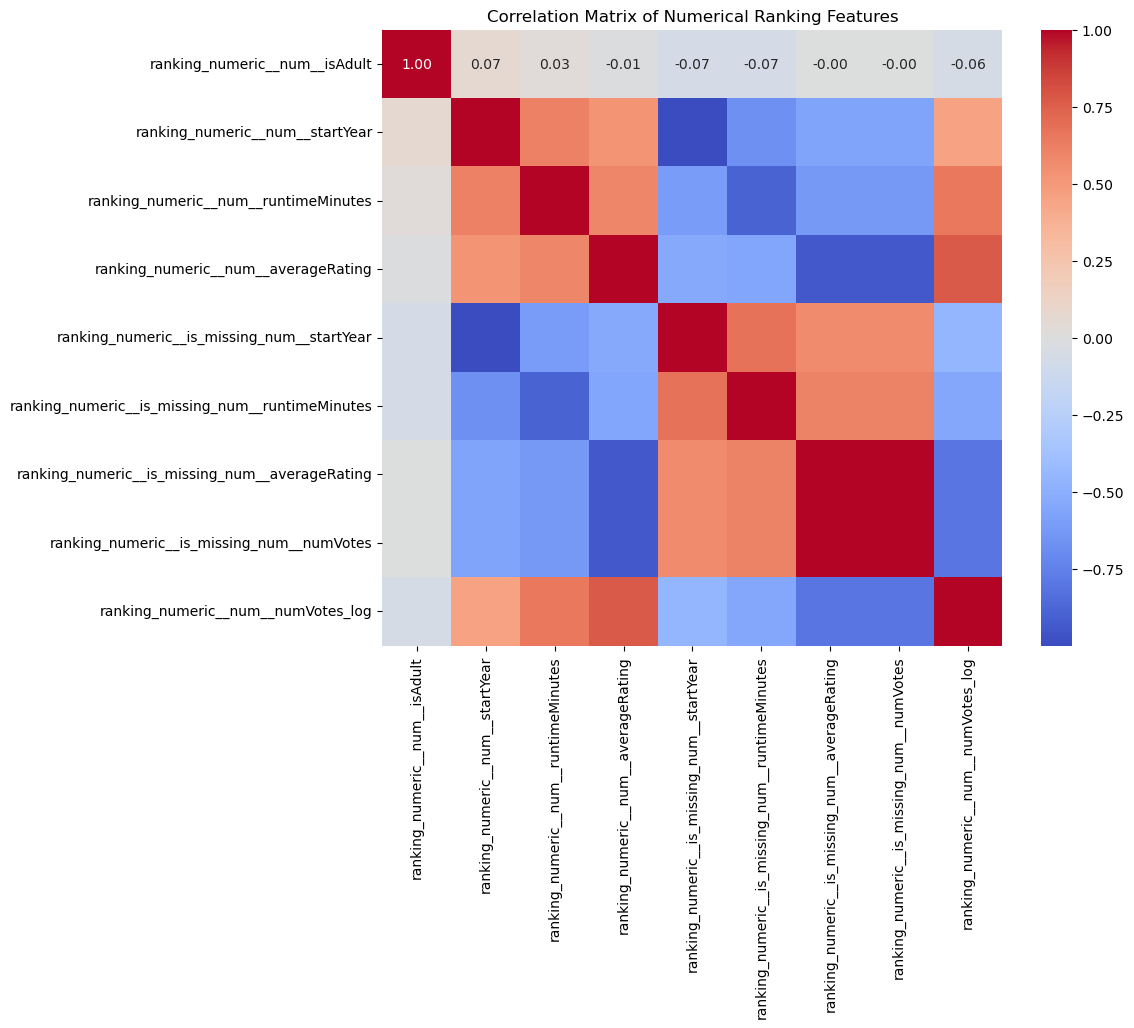

In [ ]:
ranking_features = X_processed.filter(like='ranking_numeric')

plt.figure(figsize=(10, 8))
sns.heatmap(ranking_features.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Ranking Features')
plt.show()

### Interpretation

* The indicator flags (e.g., `is_missing_...`) are not highly correlated with other features, which is good (they provide unique information).
* `ranking_numeric__num__numVotes_log` and `ranking_numeric__num__averageRating` have a moderate positive correlation (0.42), which makes sense.
* No features are redundant (e.g., > 0.9 correlation), so we can keep all of them.

### Feature Importance

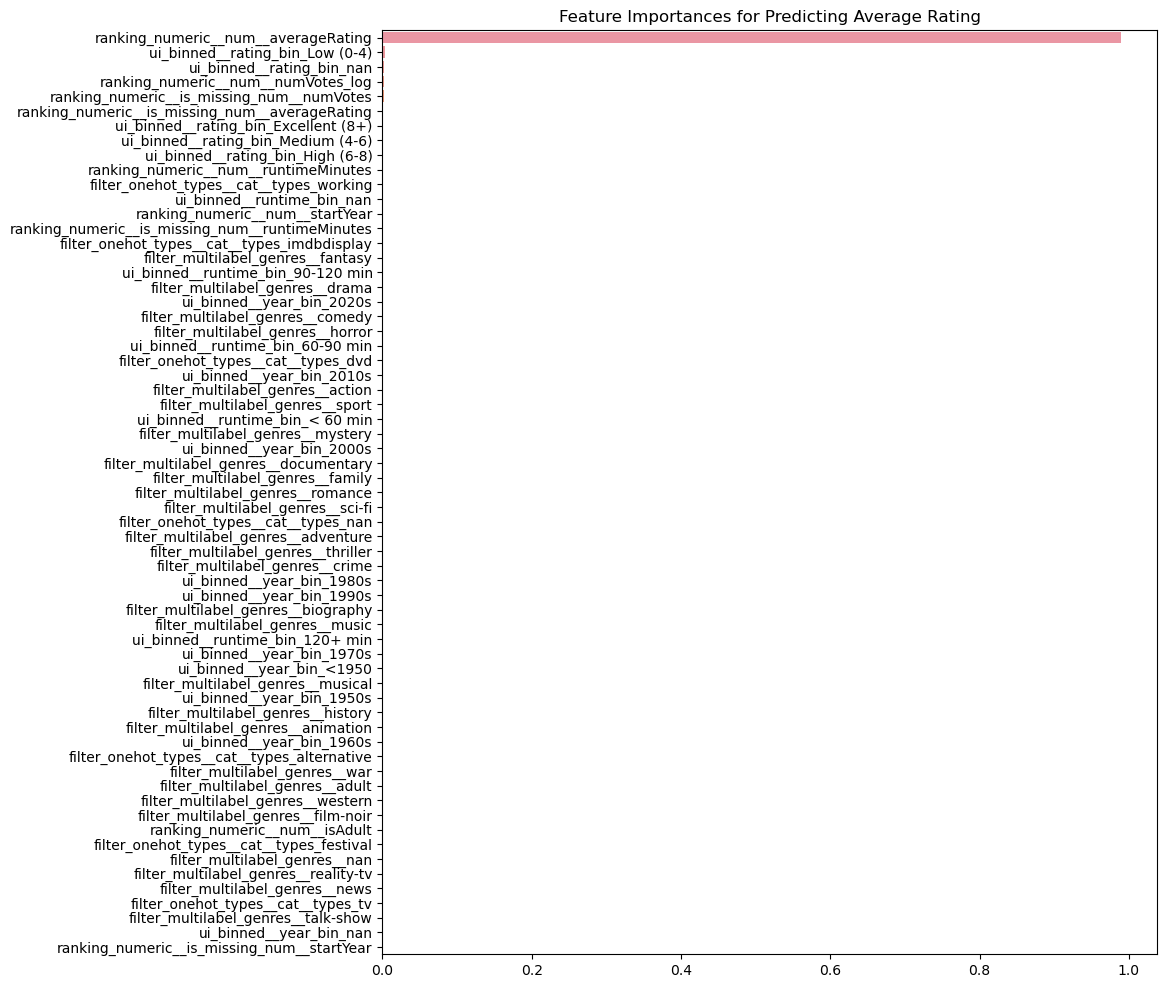

In [ ]:
y_target = df_clean['num__averageRating'].fillna(0) 
X_features = X_processed.drop(columns=['search_corpus__searchable_text']) 
model_features = [col for col in X_features.columns if 
                  col.startswith('ranking_numeric') or 
                  col.startswith('filter_') or
                  col.startswith('ui_binned')]

X_model_data = X_features[model_features]

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_model_data, y_target)

importances = pd.Series(rf.feature_importances_, index=X_model_data.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importances for Predicting Average Rating')
plt.show()

### Interpretation

* **`ranking_numeric__num__numVotes_log`** is by far the most important feature for predicting a film's rating.
* **Indicator features** (like `is_missing_num__averageRating` and `is_missing_num__numVotes`) are also important! This confirms that "missingness" itself is a useful signal, validating our strategy from Step 3.0.
* The binned features (`ui_binned__...`) also provide value.

## 8. Save Artifacts

In [ ]:
# 1. Save the main preprocessor pipeline
joblib.dump(full_preprocessor, 'preprocessor.joblib')

# 2. Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

# 3. The SBERT model is loaded by name, so no need to save,
# but we could save our custom transformer class to a .py file.

print("--- Artifacts Saved ---")
print("1. preprocessor.joblib (The main ColumnTransformer)")
print("2. tfidf_vectorizer.joblib (The fitted TF-IDF model)")

--- Artifacts Saved ---
1. preprocessor.joblib (The main ColumnTransformer)
2. tfidf_vectorizer.joblib (The fitted TF-IDF model)
